## English Premier League Analytics 
__Using Bayesian Model__


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import pymc3 as pm, theano.tensor as tt

from scipy import stats
%matplotlib inline
import datetime
RANDOM_SEED = 2009042

In [2]:
epl = pd.read_csv('epl.csv')
epl.columns

In [4]:
epl.columns[:25]

Index(['ID', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'Winner', 'Loser'],
      dtype='object')

In [5]:
epl = epl.iloc[:,:25]  ## Data Cleaning ## Removing extra columns
epl['year'] = pd.DatetimeIndex(epl['Date']).year ## Year column added

In [7]:
epl.describe()

FTHG         FTAG         HTHG         HTAG           HS  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000   
mean      1.552467     1.168363     0.703602     0.513312    13.940877   
std       1.280403     1.166446     0.832795     0.731488     5.588307   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000    10.000000   
50%       1.000000     1.000000     1.000000     0.000000    13.000000   
75%       2.000000     2.000000     1.000000     1.000000    17.000000   
max       8.000000     6.000000     5.000000     5.000000    43.000000   

                AS          HST          AST          HF           AF  \
count  2554.000000  2554.000000  2554.000000  2554.00000  2554.000000   
mean     11.061472     5.655051     4.456539    10.80971    11.257244   
std       4.719195     3.321705     2.703647     3.55900     3.632447   
min       0.000000     0.000000     0.000000     0.00000     1.000000   
25%       8.000000     3.000000     2.000000     8.00000     9.000000   
50%      11.000000     5.000000     4.000000    11.00000    11.000000   
75%      14.000000     7.000000     6.000000    13.00000    14.000000   
max      30.000000    22.000000    19.000000    33.00000    26.000000   

                HC           AC           HY           AY           HR  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000   
mean      5.925215     4.708692     1.520360     1.796006     0.062647   
std       3.095852     2.688216     1.221854     1.298213     0.258029   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.000000     3.000000     1.000000     1.000000     0.000000   
50%       6.000000     4.000000     1.000000     2.000000     0.000000   
75%       8.000000     6.000000     2.000000     3.000000     0.000000   
max      20.000000    17.000000     7.000000     9.000000     2.000000   

                AR         year  
count  2554.000000  2554.000000  
mean      0.086139  2014.122553  
std       0.290231     3.826057  
min       0.000000  2005.000000  
25%       0.000000  2012.000000  
50%       0.000000  2015.000000  
75%       0.000000  2017.000000  
max       2.000000  2019.000000

## Correlation Matrix:

In [8]:
epl.corr()

FTHG      FTAG      HTHG      HTAG        HS        AS       HST  \
FTHG  1.000000 -0.090366  0.681122 -0.060759  0.279920 -0.143308  0.463402   
FTAG -0.090366  1.000000 -0.071592  0.687351 -0.144432  0.340597 -0.145946   
HTHG  0.681122 -0.071592  1.000000 -0.058141  0.111371 -0.033036  0.277368   
HTAG -0.060759  0.687351 -0.058141  1.000000 -0.057923  0.181936 -0.089432   
HS    0.279920 -0.144432  0.111371 -0.057923  1.000000 -0.407104  0.656837   
AS   -0.143308  0.340597 -0.033036  0.181936 -0.407104  1.000000 -0.292098   
HST   0.463402 -0.145946  0.277368 -0.089432  0.656837 -0.292098  1.000000   
AST  -0.104683  0.470445 -0.047910  0.309857 -0.279318  0.657931 -0.051021   
HF   -0.066831  0.018005 -0.034895  0.017223 -0.159223  0.067979 -0.052868   
AF   -0.042275 -0.011243 -0.006509  0.008514 -0.017871 -0.073608  0.002650   
HC    0.016850 -0.084155 -0.084867 -0.018500  0.529649 -0.340765  0.349135   
AC   -0.078631  0.061742  0.023704 -0.023126 -0.337499  0.527287 -0.209267   
HY   -0.105463  0.114122 -0.080486  0.091948 -0.130244  0.126506 -0.123007   
AY   -0.007344 -0.000849 -0.013196  0.003067  0.039154 -0.053384  0.044170   
HR   -0.065675  0.145839 -0.017456  0.076515 -0.111521  0.122931 -0.075775   
AR    0.066887 -0.057897  0.021404 -0.023854  0.097328 -0.081940  0.089340   
year  0.013599  0.049966 -0.009985  0.048051  0.053283  0.065553 -0.304105   

           AST        HF        AF        HC        AC        HY        AY  \
FTHG -0.104683 -0.066831 -0.042275  0.016850 -0.078631 -0.105463 -0.007344   
FTAG  0.470445  0.018005 -0.011243 -0.084155  0.061742  0.114122 -0.000849   
HTHG -0.047910 -0.034895 -0.006509 -0.084867  0.023704 -0.080486 -0.013196   
HTAG  0.309857  0.017223  0.008514 -0.018500 -0.023126  0.091948  0.003067   
HS   -0.279318 -0.159223 -0.017871  0.529649 -0.337499 -0.130244  0.039154   
AS    0.657931  0.067979 -0.073608 -0.340765  0.527287  0.126506 -0.053384   
HST  -0.051021 -0.052868  0.002650  0.349135 -0.209267 -0.123007  0.044170   
AST   1.000000  0.111370 -0.016111 -0.181470  0.336869  0.104967 -0.008944   
HF    0.111370  1.000000  0.131527 -0.116474  0.029618  0.367675  0.091462   
AF   -0.016111  0.131527  1.000000 -0.008181 -0.040178  0.080233  0.372287   
HC   -0.181470 -0.116474 -0.008181  1.000000 -0.291838 -0.086320  0.028559   
AC    0.336869  0.029618 -0.040178 -0.291838  1.000000  0.069065 -0.048349   
HY    0.104967  0.367675  0.080233 -0.086320  0.069065  1.000000  0.167449   
AY   -0.008944  0.091462  0.372287  0.028559 -0.048349  0.167449  1.000000   
HR    0.126306  0.088056  0.035456 -0.044148  0.062461  0.039437  0.072076   
AR   -0.034662  0.021563  0.094151  0.062972 -0.070744  0.024875  0.052893   
year -0.248699 -0.195301 -0.172809 -0.032890 -0.011723  0.020036 -0.071931   

            HR        AR      year  
FTHG -0.065675  0.066887  0.013599  
FTAG  0.145839 -0.057897  0.049966  
HTHG -0.017456  0.021404 -0.009985  
HTAG  0.076515 -0.023854  0.048051  
HS   -0.111521  0.097328  0.053283  
AS    0.122931 -0.081940  0.065553  
HST  -0.075775  0.089340 -0.304105  
AST   0.126306 -0.034662 -0.248699  
HF    0.088056  0.021563 -0.195301  
AF    0.035456  0.094151 -0.172809  
HC   -0.044148  0.062972 -0.032890  
AC    0.062461 -0.070744 -0.011723  
HY    0.039437  0.024875  0.020036  
AY    0.072076  0.052893 -0.071931  
HR    1.000000  0.058673 -0.043092  
AR    0.058673  1.000000 -0.074414  
year -0.043092 -0.074414  1.000000

In [9]:
epl=epl.drop(["FTR","HTR","Referee"],axis=1)

## Some Analysis :

In [10]:
def team(year,name):
    eplyear=epl[epl["year"]==year]
    totalGames= eplyear[eplyear["HomeTeam"] ==name].append(eplyear[eplyear["AwayTeam"] ==name])
    return totalGames

def teams(name1,name2):
    
    totalGames= epl[epl["HomeTeam"] ==name1]
    totalGames=totalGames[totalGames["AwayTeam"] ==name2]
    
    return totalGames

def teamHome(name1):
    
    totalGames= epl[epl["HomeTeam"] ==name1]
    
    return totalGames
teamHome("Arsenal")
#team(2011,"Arsenal")
#teams("Arsenal","Everton")

ID        Date HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  HS  AS  \
2      3   14-Aug-05  Arsenal       Newcastle     2     0     0     0  15   2   
11    12   19-Sep-05  Arsenal         Everton     2     0     2     0  11   4   
19    20   22-Oct-05  Arsenal        Man City     1     0     0     0   4   7   
38    39   18-Dec-05  Arsenal         Chelsea     0     2     0     1   7  11   
47    48    3-Jan-06  Arsenal      Man United     0     0     0     0   8  16   
...   ..         ...      ...             ...   ...   ...   ...   ...  ..  ..   
2447  E0  27/02/2019  Arsenal     Bournemouth     5     1     2     1  16  13   
2470  E0   10/3/2019  Arsenal      Man United     2     0     1     0  14  14   
2487  E0    1/4/2019  Arsenal       Newcastle     2     0     1     0   7   3   
2516  E0  21/04/2019  Arsenal  Crystal Palace     2     3     0     1  12  16   
2540  E0    5/5/2019  Arsenal        Brighton     1     1     1     0  20  11   

      ...  AF  HC  AC  HY  AY  HR  AR   Winner      Loser  year  
2     ...  17   8   3   0   1   0   1  Arsenal  Newcastle  2005  
11    ...  19   4   0   2   3   0   0  Arsenal    Everton  2005  
19    ...  17   4   3   3   5   0   0  Arsenal   Man City  2005  
38    ...  18   5   5   3   4   0   0  Chelsea    Arsenal  2005  
47    ...  13   6   9   2   3   0   0     None       None  2006  
...   ...  ..  ..  ..  ..  ..  ..  ..      ...        ...   ...  
2447  ...   9   9   4   2   2   0   0     1.44          5  2019  
2470  ...  18   5   2   2   2   0   0      2.4        3.6  2019  
2487  ...  10   6   2   2   0   0   0     1.36       5.25  2019  
2516  ...  12   8   3   4   1   0   0     1.53        4.6  2019  
2540  ...  14  16   3   5   2   0   0      1.4          5  2019  

[175 rows x 23 columns]

## To get correlation between the Attributes to Win or Lose the Game: 
__(HeatMap)__

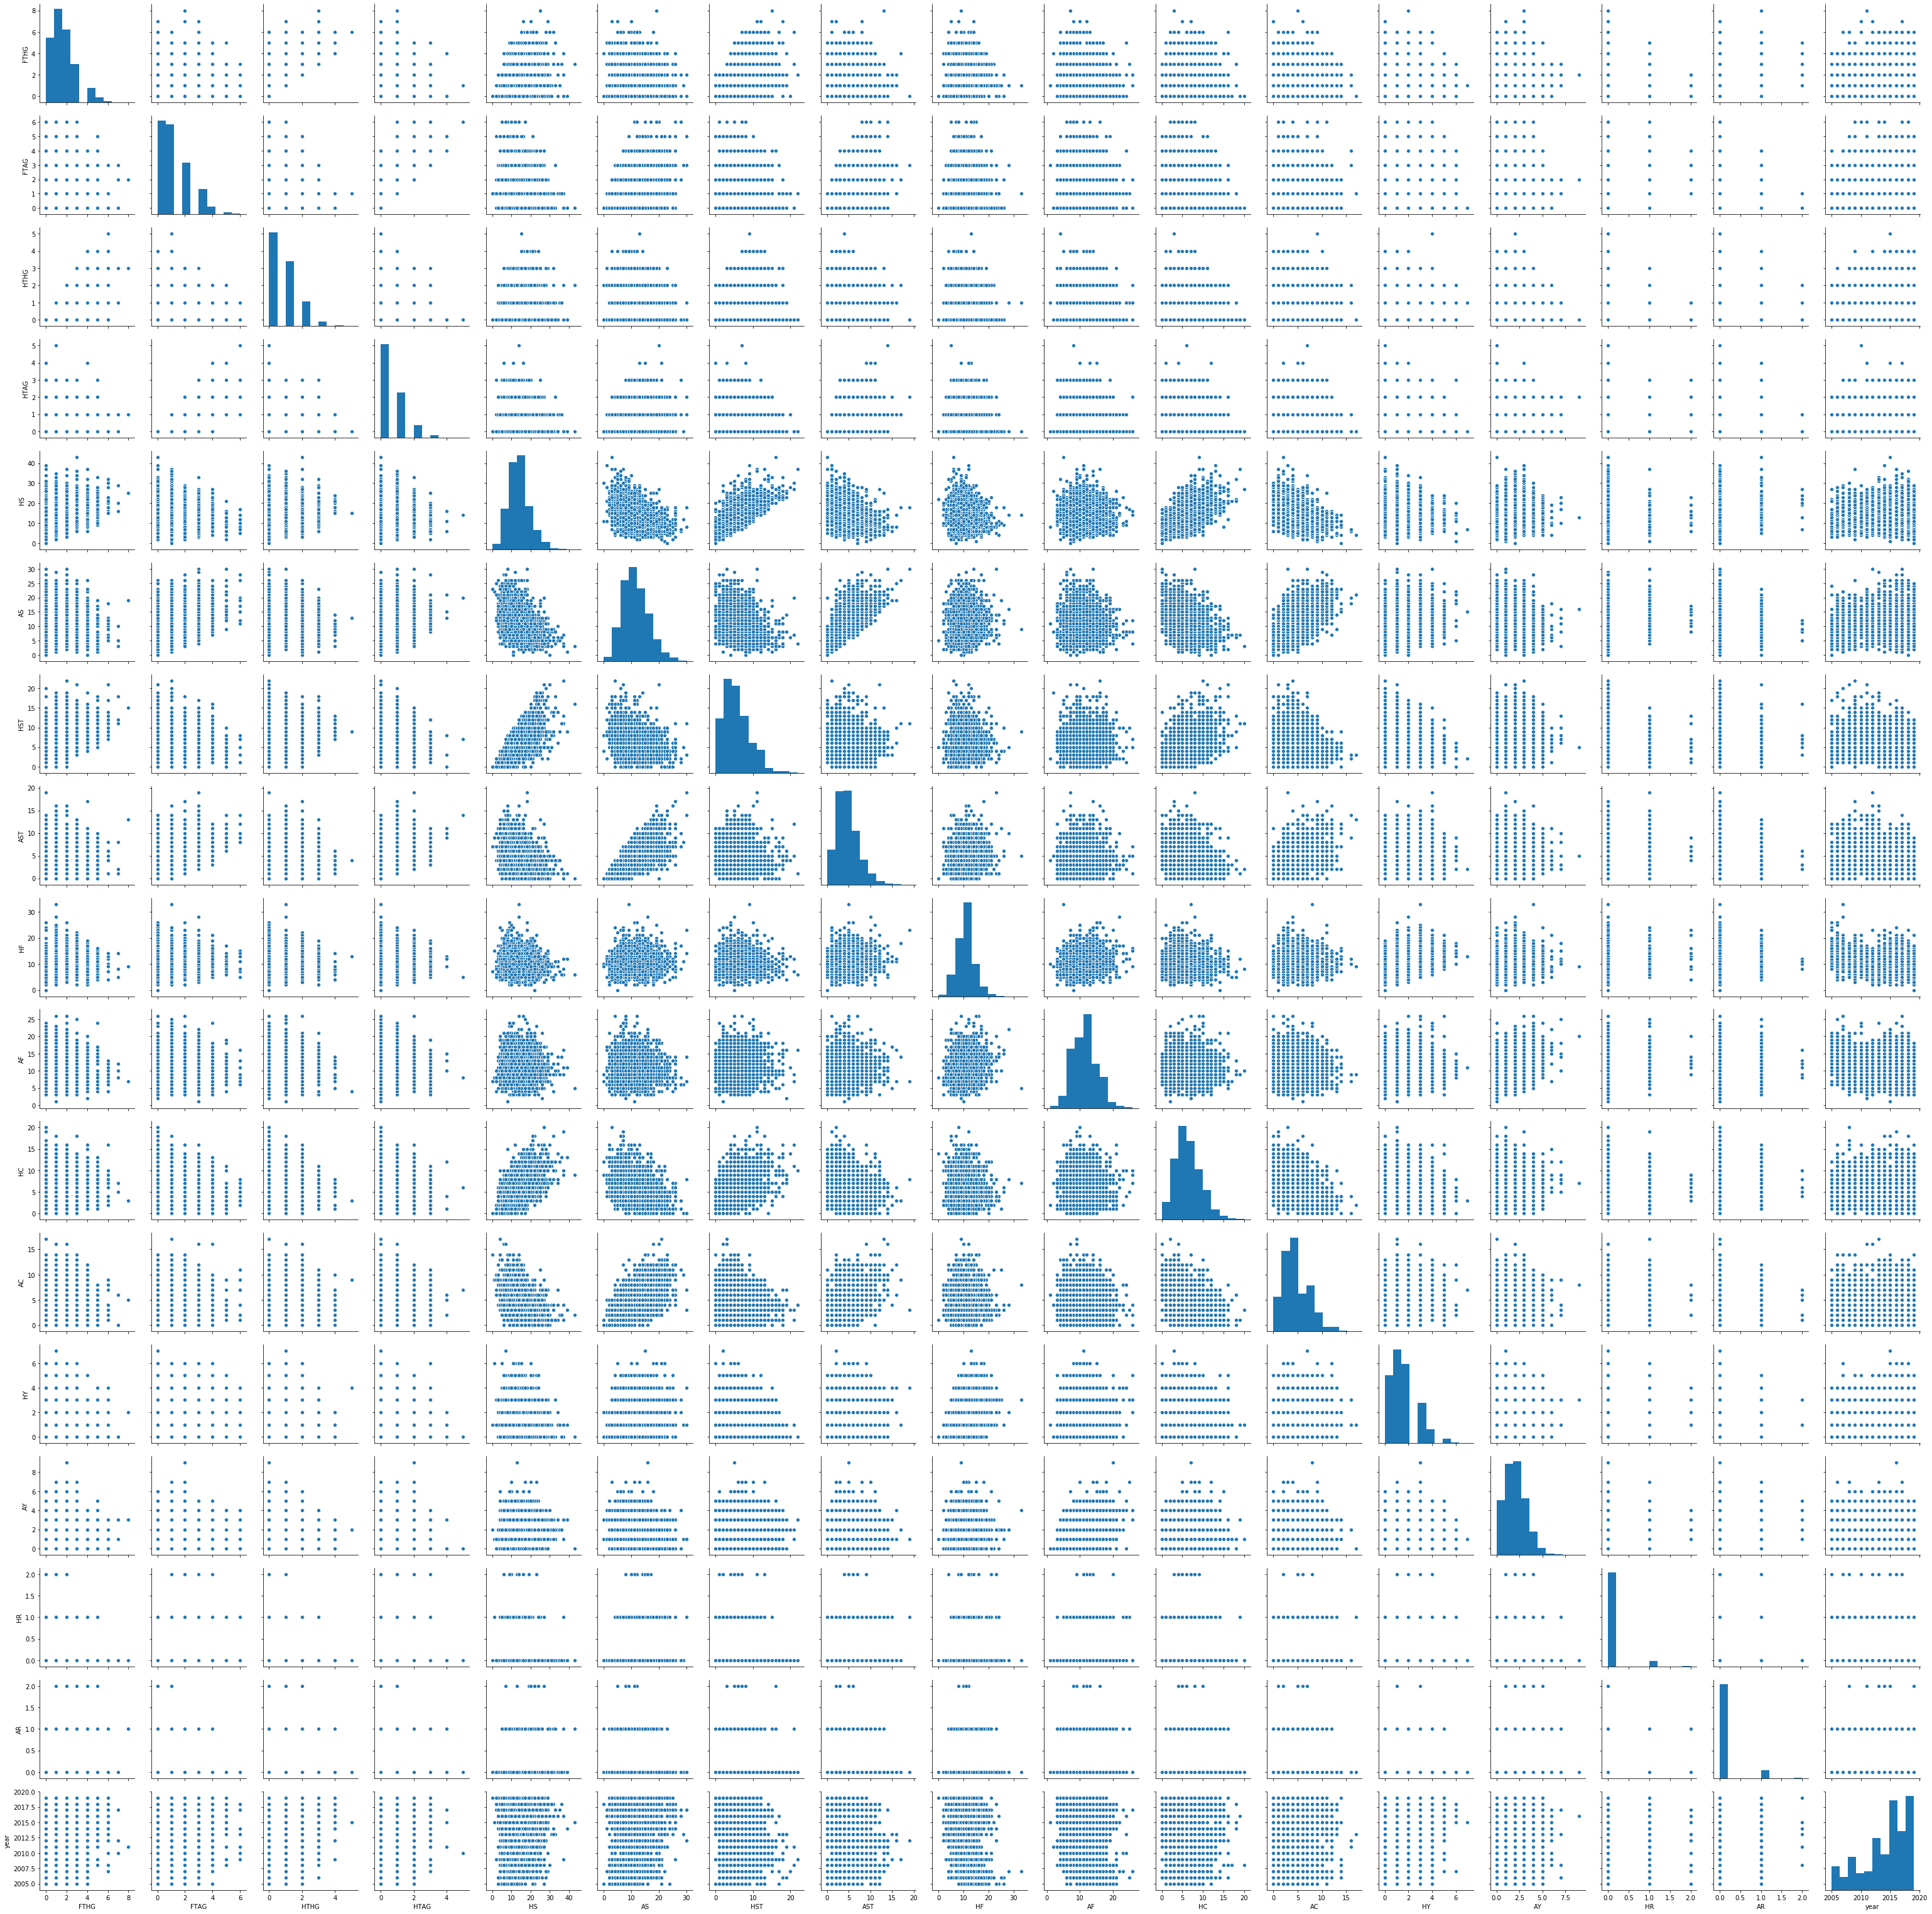

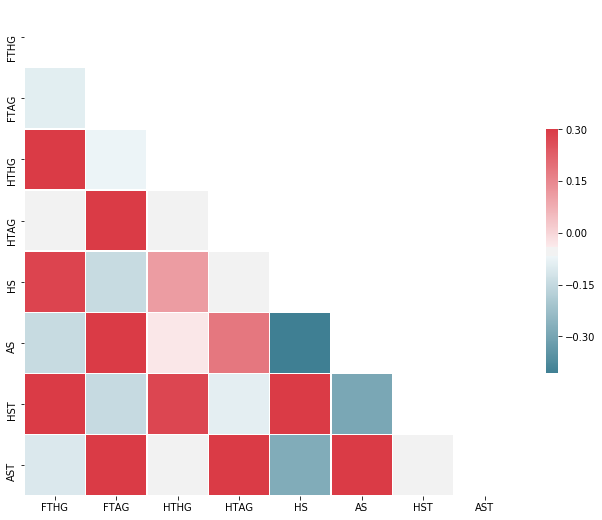

In [12]:
g = sns.pairplot(epl)
epl_1= epl[['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','Winner','Loser']]
corr = epl_1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [13]:
epl_all = epl[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
epl_all

HomeTeam      AwayTeam  FTHG  FTAG
0         Everton    Man United     0     2
1        Man City     West Brom     0     0
2         Arsenal     Newcastle     2     0
3       Newcastle      West Ham     0     0
4         Chelsea       Arsenal     1     0
...           ...           ...   ...   ...
2549    Liverpool        Wolves     2     0
2550   Man United       Cardiff     0     2
2551  Southampton  Huddersfield     1     1
2552    Tottenham       Everton     2     2
2553      Watford      West Ham     1     4

[2554 rows x 4 columns]

In [14]:
teams = epl['HomeTeam'].unique()
teams = pd.DataFrame(teams, columns=['teams'])
teams['i'] = teams.index
teams

teams   i
0          Everton   0
1         Man City   1
2          Arsenal   2
3        Newcastle   3
4          Chelsea   4
5        Tottenham   5
6       Man United   6
7        Liverpool   7
8         West Ham   8
9        West Brom   9
10         Watford  10
11           Stoke  11
12         Burnley  12
13         Swansea  13
14     Southampton  14
15  Crystal Palace  15
16       Leicester  16
17     Bournemouth  17
18        Brighton  18
19    Huddersfield  19
20          Fulham  20
21          Wolves  21
22         Cardiff  22

In [15]:
epl_all = pd.merge(epl_all, teams, left_on='HomeTeam', right_on='teams', how='left')
epl_all = epl_all.rename(columns = {'i': 'home'}).drop('teams', 1)
epl_all = pd.merge(epl_all, teams, left_on='AwayTeam', right_on='teams', how='left')
epl_all = epl_all.rename(columns = {'i': 'away'}).drop('teams', 1)
epl_all

HomeTeam      AwayTeam  FTHG  FTAG  home  away
0         Everton    Man United     0     2     0     6
1        Man City     West Brom     0     0     1     9
2         Arsenal     Newcastle     2     0     2     3
3       Newcastle      West Ham     0     0     3     8
4         Chelsea       Arsenal     1     0     4     2
...           ...           ...   ...   ...   ...   ...
2549    Liverpool        Wolves     2     0     7    21
2550   Man United       Cardiff     0     2     6    22
2551  Southampton  Huddersfield     1     1    14    19
2552    Tottenham       Everton     2     2     5     0
2553      Watford      West Ham     1     4    10     8

[2554 rows x 6 columns]

In [16]:
observed_home_goals = epl_all['FTHG'].values
observed_away_goals = epl_all['FTAG'].values

home_team = epl_all['home'].values
away_team = epl_all['away'].values

num_teams = len(teams)
num_games = len(home_team)
num_teams, num_games

(23, 2554)

In [17]:
g1 = epl_all.groupby('away')
att_starting_points = np.log(g1['FTAG'].mean())
g2 = epl_all.groupby('home')
def_starting_points = -np.log(g2['FTHG'].mean())
def_starting_points

home
0    -0.407368
1    -0.775385
2    -0.678758
3    -0.302571
4    -0.684539
5    -0.542324
6    -0.631272
7    -0.698845
8    -0.269333
9    -0.195061
10   -0.173847
11   -0.188711
12   -0.050010
13   -0.155564
14   -0.316799
15   -0.106380
16   -0.361370
17   -0.336472
18   -0.123614
19    0.379490
20   -0.146603
21   -0.387766
22   -0.100083
Name: FTHG, dtype: float64

In [18]:
with pm.Model() as model:
    home = pm.Flat('home') #flat pdf is uninformative 
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') 

    # team-specific model parameters. 
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)
    #There is one (atts_star, defs_star) tuple per team.
    
    
    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])  
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    # tt is theano.tensor

    # likelihood of observed data, Poisson distribution for coutn data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:24<00:00, 163.16draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\khist\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:155: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (96), generating only 40 plots
  SyntaxWarning,


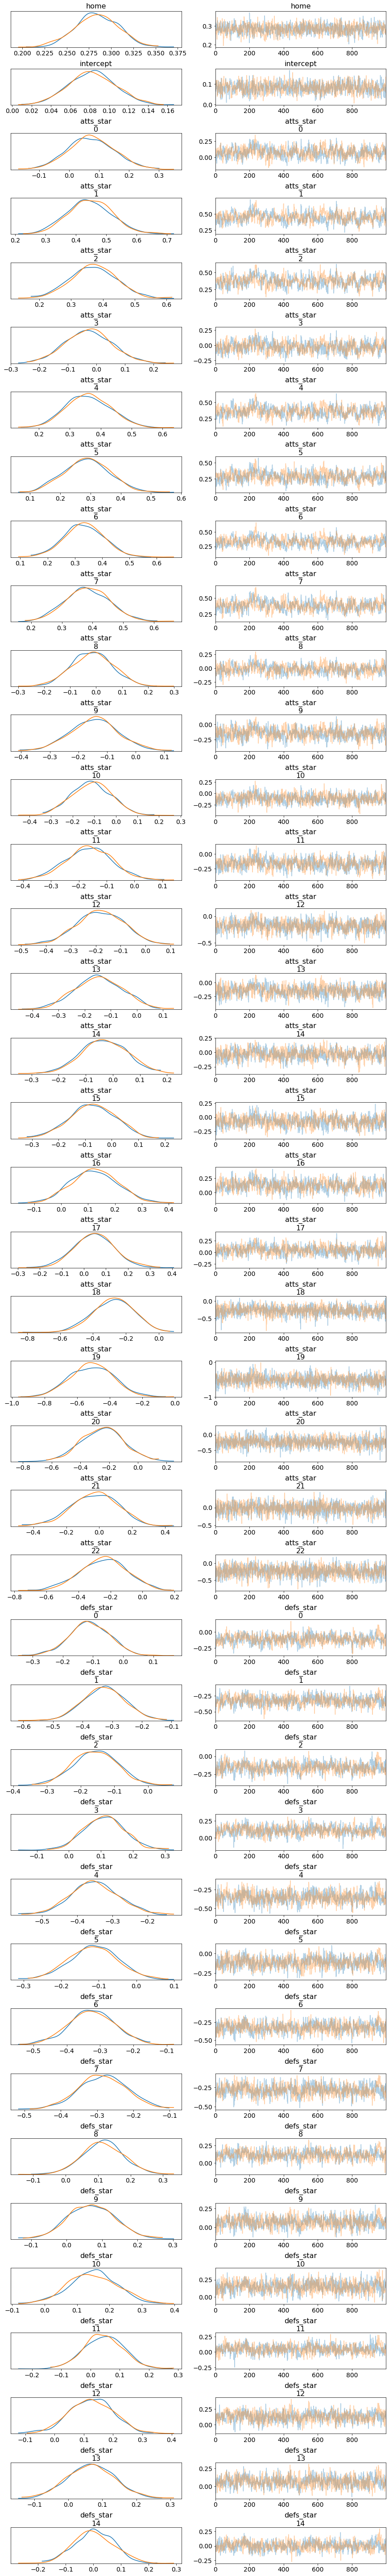

In [19]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)
    pm.traceplot(trace)

In [20]:
#pm.stats.hpd(trace['atts'])

In [21]:
#pm.stats.quantiles(trace['atts'])

## Attack Strengths:

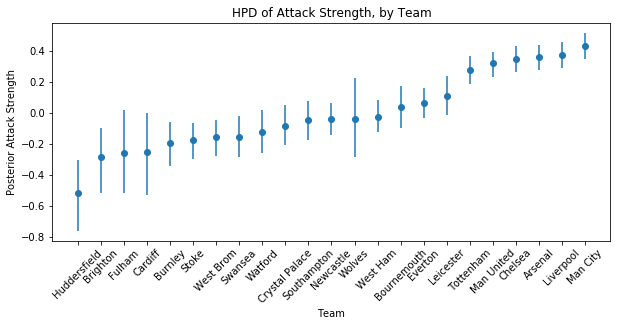

In [22]:
epl_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.teams.values)
epl_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.teams.values)
epl_hpd = epl_hpd.join(epl_median)
epl_hpd['RelativeLower'] = epl_hpd.hpd_median - epl_hpd.hpd_low
epl_hpd['RelativeUpper'] = epl_hpd.hpd_high - epl_hpd.hpd_median
epl_hpd = epl_hpd.sort_values(by='hpd_median')
epl_hpd = epl_hpd.reset_index()
epl_hpd['x'] = epl_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(epl_hpd.x, epl_hpd.hpd_median,
             yerr=(epl_hpd[['RelativeLower', 'RelativeUpper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(epl_hpd.index + .5)
_= axs.set_xticklabels(epl_hpd['index'].values, rotation=45)

## Defense Strengths:

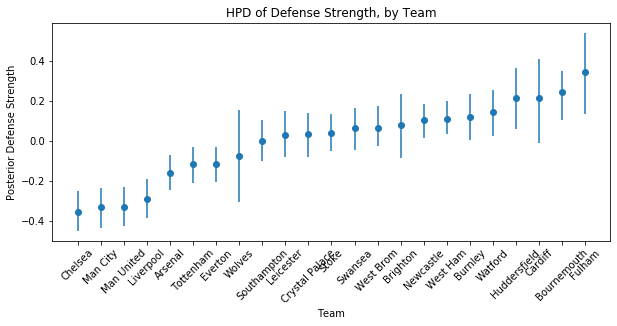

In [23]:
epl_hpd = pd.DataFrame(pm.stats.hpd(trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.teams.values)
epl_median = pd.DataFrame(pm.stats.quantiles(trace['defs'])[50],
                         columns=['hpd_median'],
                         index=teams.teams.values)
epl_hpd = epl_hpd.join(epl_median)
epl_hpd['RelativeLower'] = epl_hpd.hpd_median - epl_hpd.hpd_low
epl_hpd['RelativeUpper'] = epl_hpd.hpd_high - epl_hpd.hpd_median
epl_hpd = epl_hpd.sort_values(by='hpd_median')
epl_hpd = epl_hpd.reset_index()
epl_hpd['x'] = epl_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(epl_hpd.x, epl_hpd.hpd_median,
             yerr=(epl_hpd[['RelativeLower', 'RelativeUpper']].values).T,
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(epl_hpd.index + .5)
_= axs.set_xticklabels(epl_hpd['index'].values, rotation=45)

## Posterior Probabilities :

C:\Users\khist\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


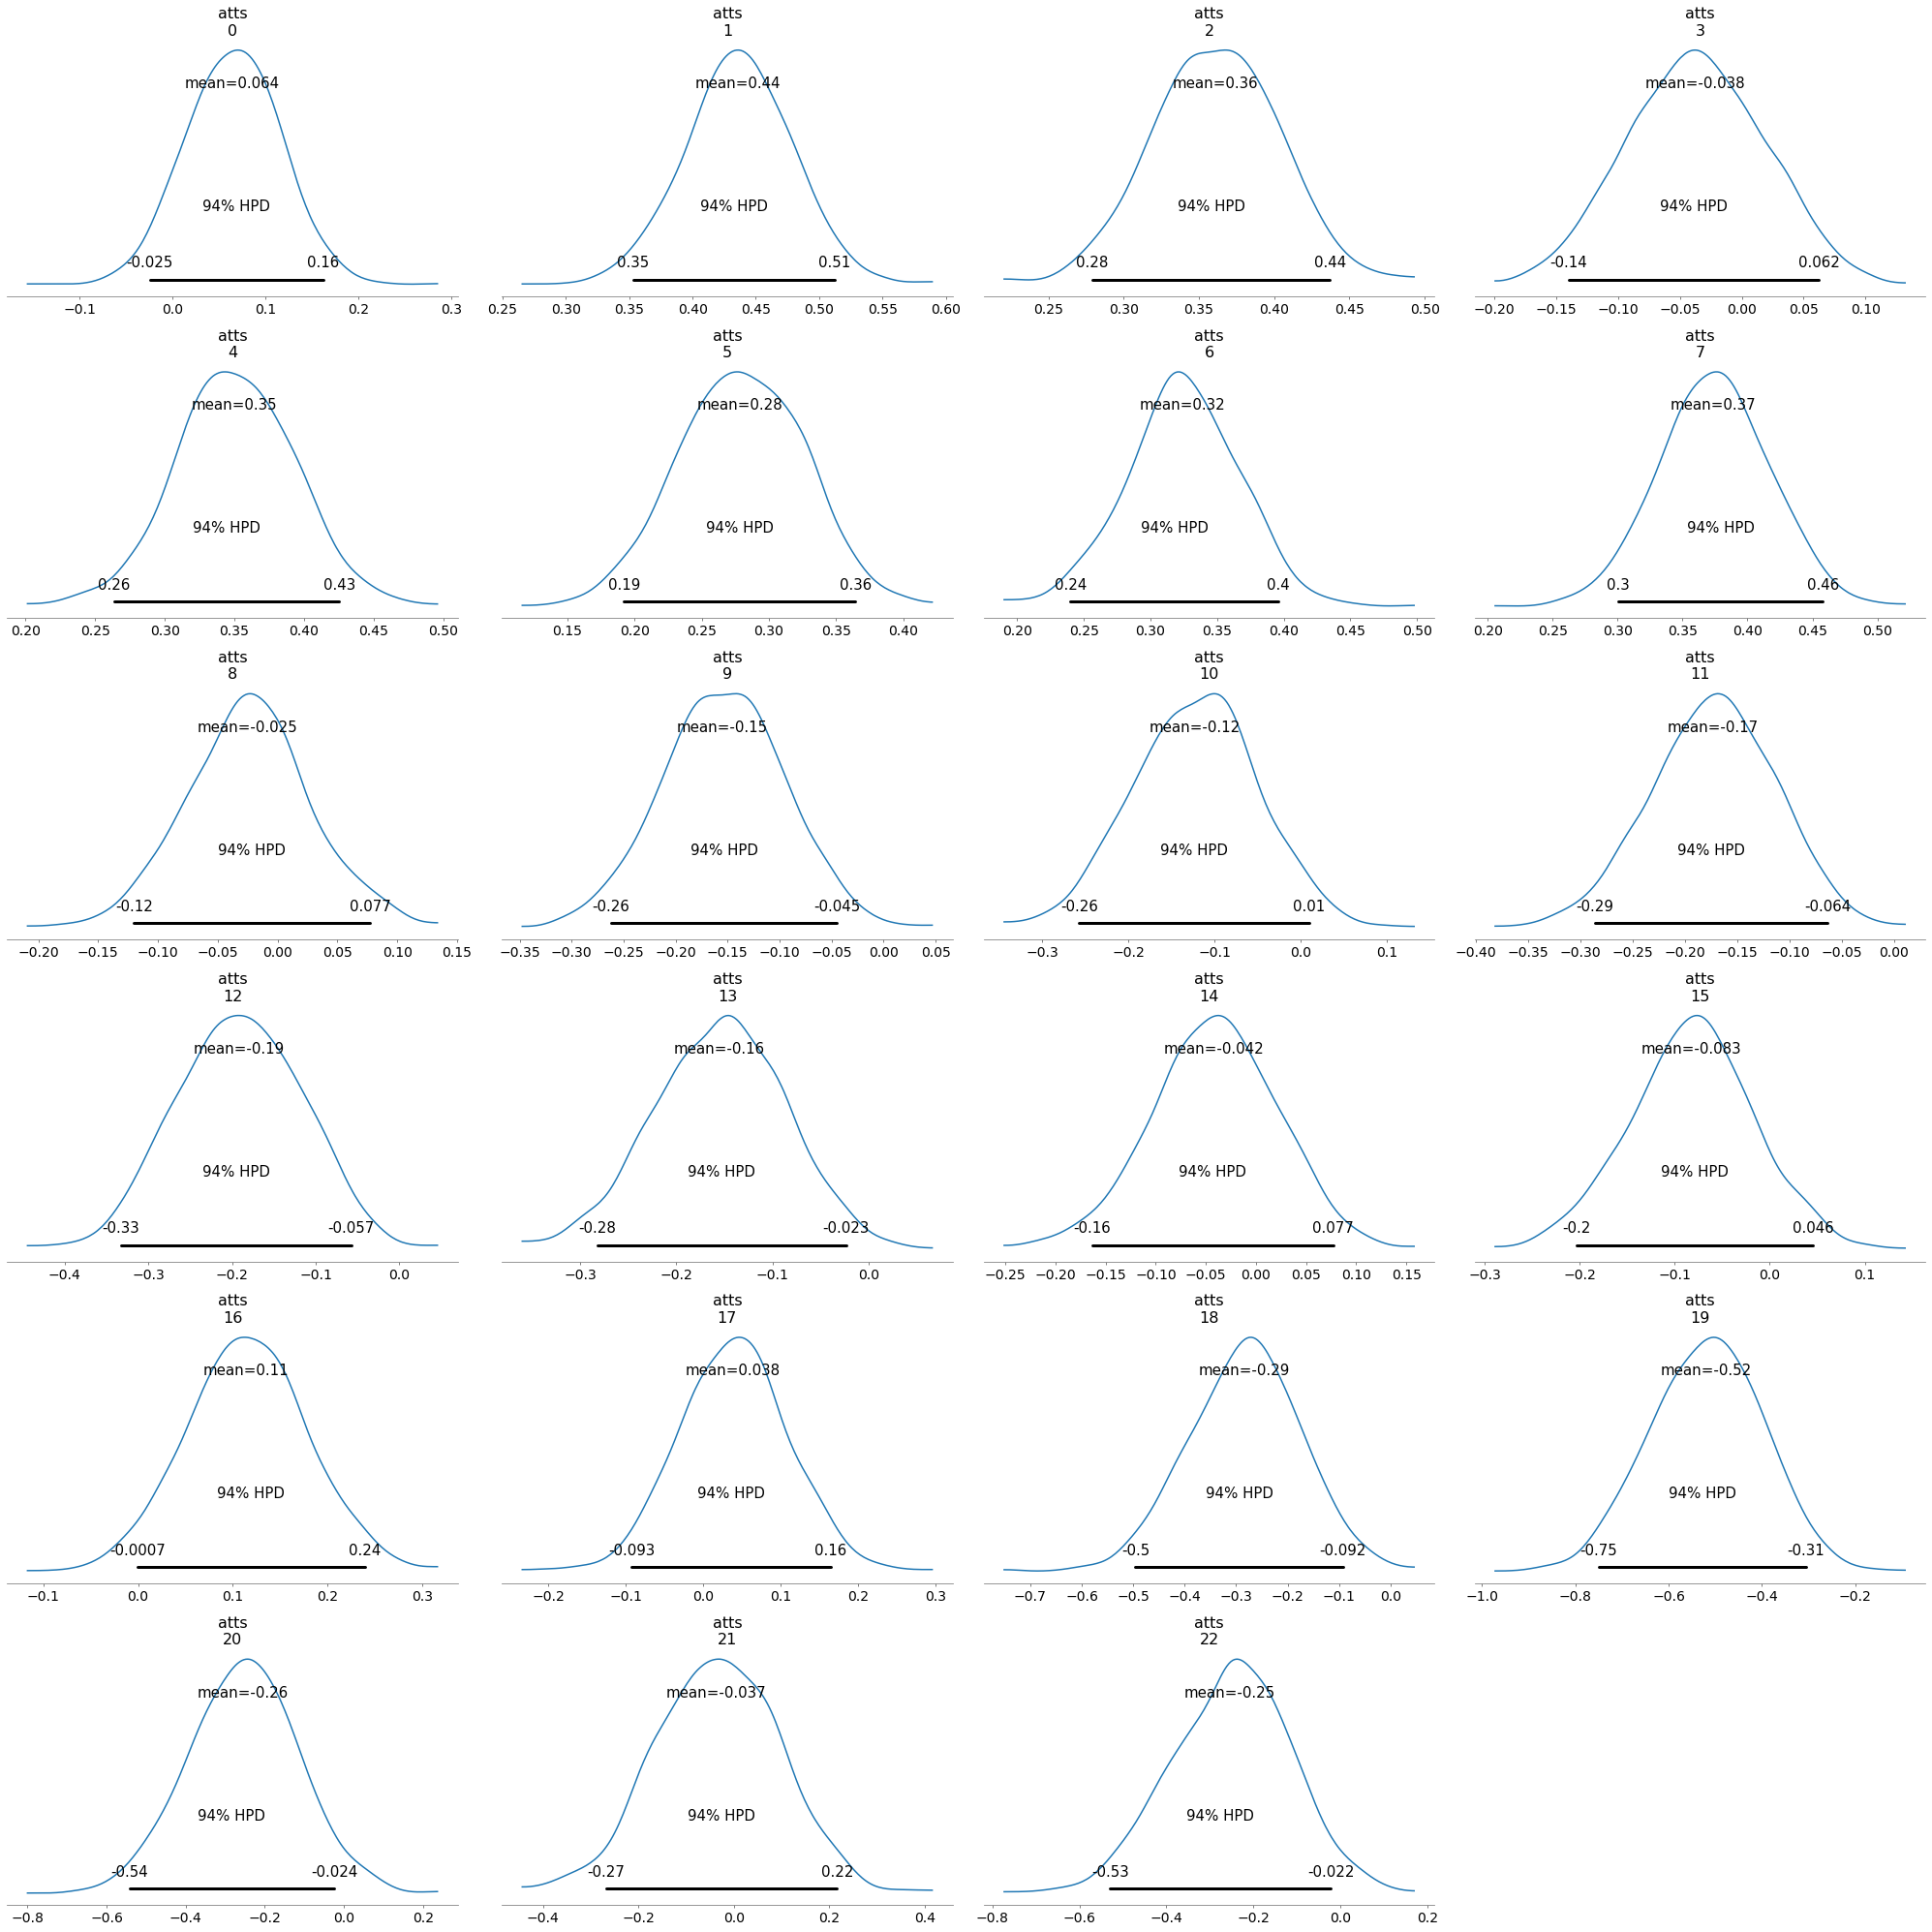

In [25]:
pm.plot_posterior(trace, varnames=['atts']);

In [26]:
with model:
    pp_trace = pm.sample_ppc(trace)

C:\Users\khist\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 624.91it/s]


In [27]:
home_sim_epl = pd.DataFrame({ 'sim_points_{}'.format(i): 3 * home_won 
                             for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
                            })

home_sim_epl.insert(0, 'team', epl['HomeTeam'])

away_sim_epl = pd.DataFrame({ 'sim_points_{}'.format(i): 3 * away_won
                            for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
                            })

away_sim_epl.insert(0, 'team', epl['AwayTeam'])

In [28]:
sim_table = (home_sim_epl.groupby('team')
                        .sum()
                        .add(away_sim_epl.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

## Winning Odds for Teams based on maximum points:

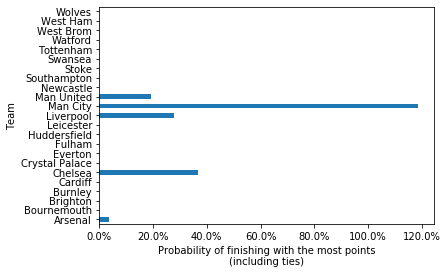

In [29]:

ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n(including ties)");

ax.set_ylabel("Team");

## Correlations of Attacking Strengths between the top Teams:

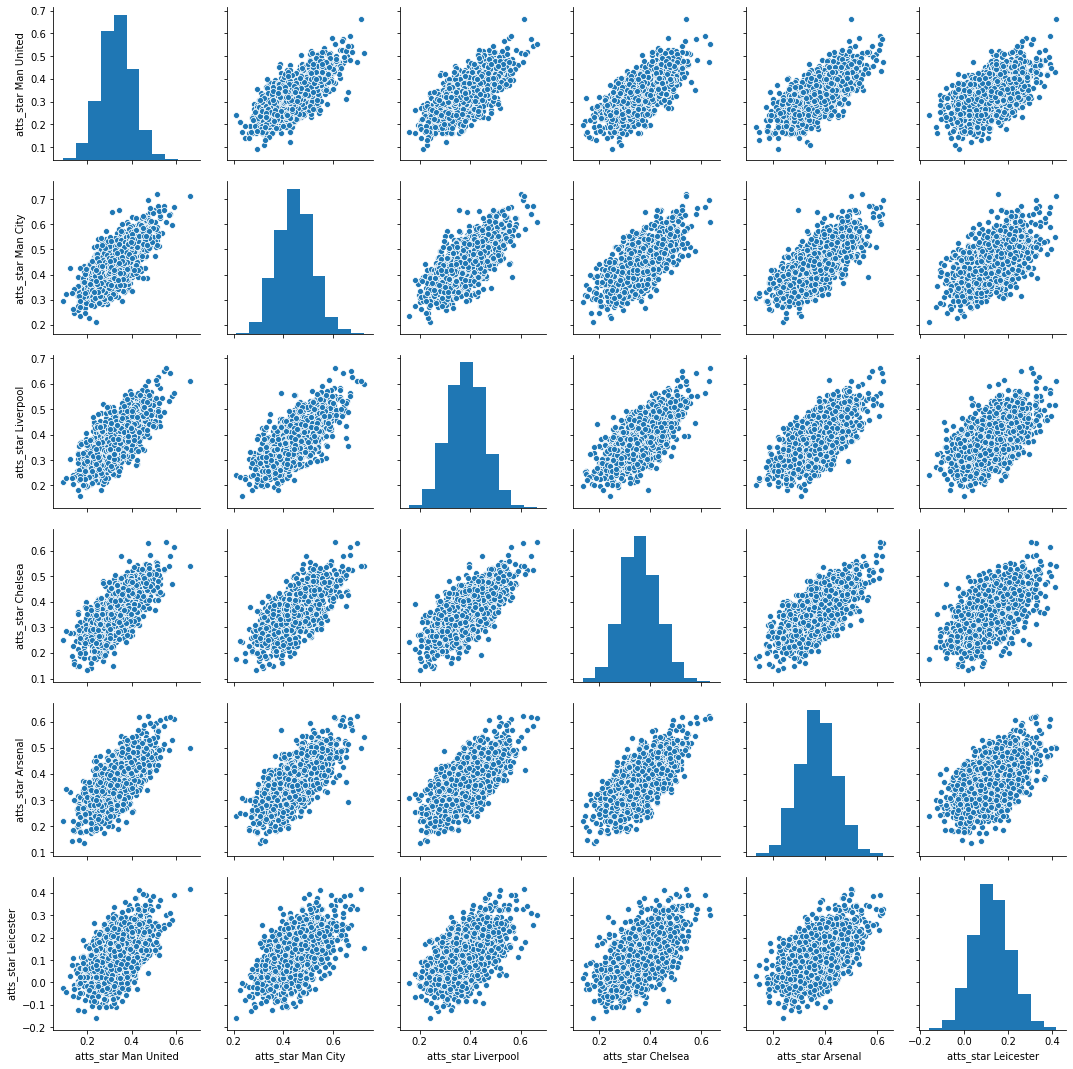

In [30]:
epl_trace = pm.trace_to_dataframe(trace)
cols = {
    'atts_star__6': 'atts_star Man United',
    'atts_star__1': 'atts_star Man City',
    'atts_star__7': 'atts_star Liverpool',
    'atts_star__4': 'atts_star Chelsea',
    'atts_star__2': 'atts_star Arsenal',
    'atts_star__16': 'atts_star Leicester'
}

epl_trace_att = epl_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(epl_trace_att)

## Correlations of defencing strengths between the top Teams:

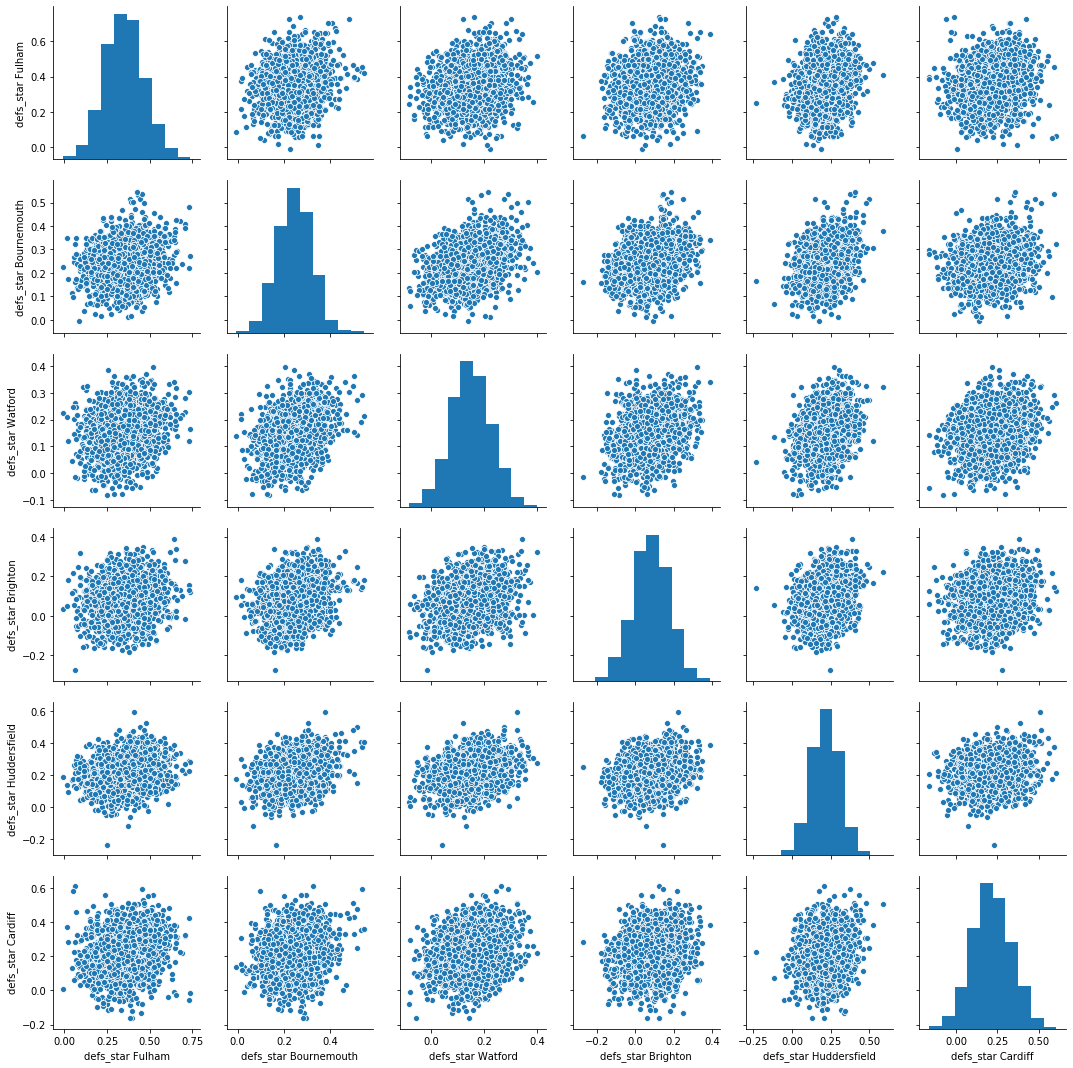

In [31]:
cols = {
    'defs_star__20': 'defs_star Fulham',
    'defs_star__17': 'defs_star Bournemouth',
    'defs_star__10': 'defs_star Watford',
    'defs_star__18': 'defs_star Brighton',
    'defs_star__19': 'defs_star Huddersfield',
    'defs_star__22': 'defs_star Cardiff'
}

epl_trace_def = epl_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(epl_trace_def)

# Conclusion : 


In this project, I used Baysian model to predict defensing strength and attacking strength for Teams with respect to each other based on the matches played.<br> 
1.Man City has highest winning odd based on the points. <br> 
2.Fulham has highest defense strength and Chelsea has lowest. <br>
3.Man City has highest attack strength and Huddersfield has lowest. <br>

# Licensing

__Copyright 2020 Pranav Sanjay Khiste__

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.